In [25]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import community as community_louvain
from sklearn.cluster import SpectralClustering
from networkx.algorithms.community import modularity
from sklearn.preprocessing import StandardScaler
import numpy as np

%matplotlib inline

### Reading data

In [31]:
# Load the preprocessed data
preprocessed_df = pd.read_csv('players_preprocessed.csv')

# Taking only 1000 entries for the sake of computation
preprocessed_df = preprocessed_df.iloc[:5000]

# Columns to use
columns_to_use = preprocessed_df[['short_name', 'age', 'pace', 'shooting', 'passing',
       'dribbling', 'defending', 'weak_foot']]

# Exclude short_name for similarity calculation
attributes_df = preprocessed_df[['age', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'weak_foot']]

In [32]:
# Compute cosine similarity matrix for the attributes
similarity_matrix = cosine_similarity(attributes_df)

### Setting up graph

In [33]:
# Create a new graph
G = nx.Graph()

# Add nodes with player names as identifiers
for idx, row in preprocessed_df.iterrows():
    G.add_node(row['short_name'], age=row['age'], pace=row['pace'], shooting=row['shooting'],
               passing=row['passing'], dribbling=row['dribbling'], defending=row['defending'], 
               weak_foot=row['weak_foot'])


# Add edges based on similarity threshold
similarity_threshold = 0.9  # Define a threshold for similarity
for i in range(len(preprocessed_df)):
    for j in range(i + 1, len(preprocessed_df)):
        if similarity_matrix[i, j] > similarity_threshold:
            G.add_edge(preprocessed_df.loc[i, 'short_name'], preprocessed_df.loc[j, 'short_name'],
                       weight=similarity_matrix[i, j])

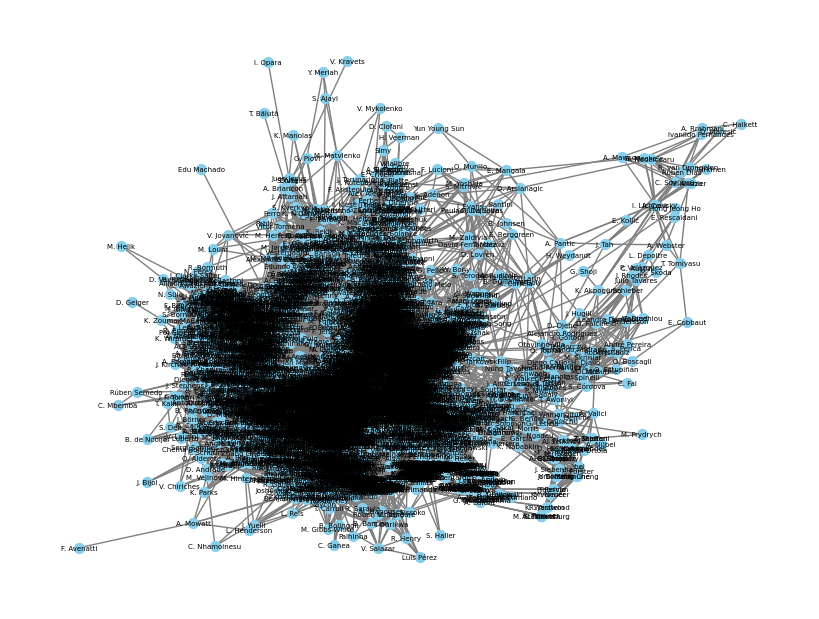

In [39]:
# Visualizing the entire graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_size=50, font_size=5, node_color="skyblue", edge_color="gray")
plt.show()

### Louvain communities

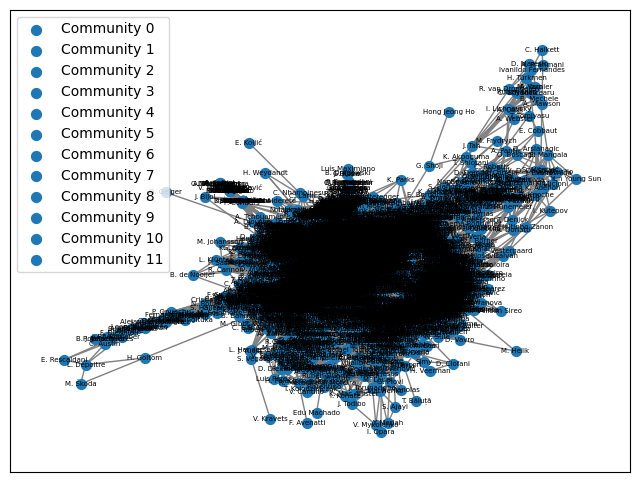

In [ ]:
# Apply the Louvain algorithm to detect communities
partition = community_louvain.best_partition(G)

# Draw the graph with nodes colored by community
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)

# Draw nodes with color based on their community
for community_id in set(partition.values()):
    members = [node for node in partition if partition[node] == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=members, node_size=50, label=f"Community {community_id}")

# Visualizing communities
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.5)
nx.draw_networkx_labels(G, pos, font_size=5, font_color="black")
plt.legend()
plt.show()

/var/folders/q5/kv3lnx553934jm0hgvrsxwrr0000gn/T/ipykernel_22568/1750124351.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_communities))  # Choose a colormap


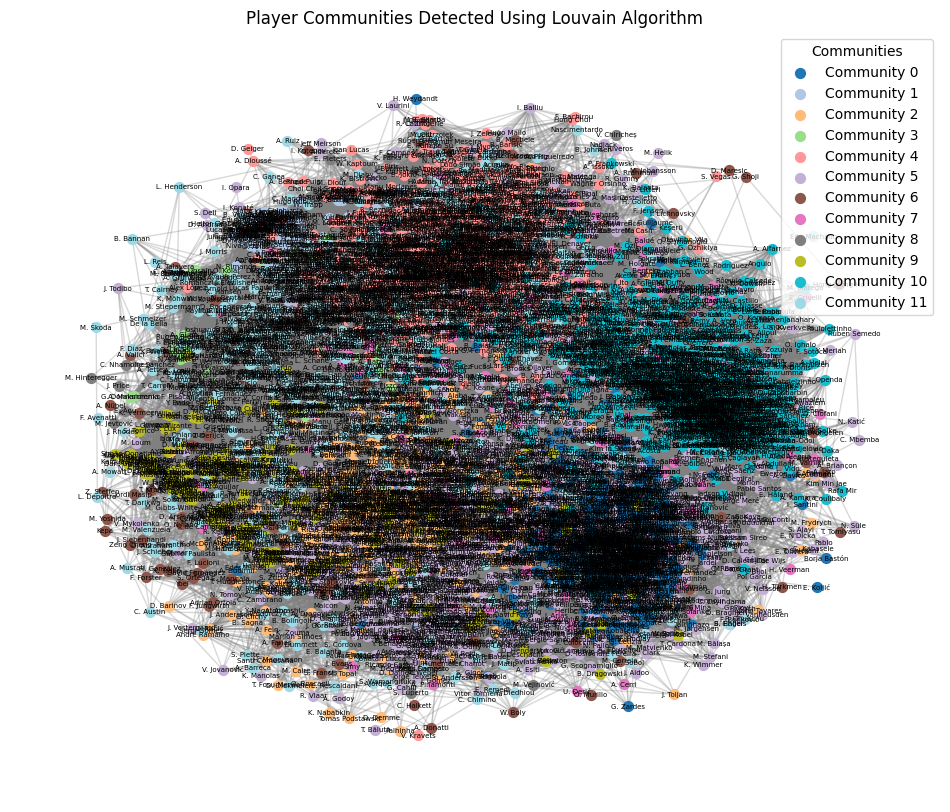

In [ ]:
# Making a prettier plot :)
pos = nx.spring_layout(G, k=0.3, seed=42)  # 'k' spread nodes apart

# Generate a color map for the communities
unique_communities = set(partition.values())
color_map = plt.cm.get_cmap('tab20', len(unique_communities)) 

# Draw nodes with colors based on their community
plt.figure(figsize=(12, 10))
for community_id in unique_communities:
    members = [node for node in partition if partition[node] == community_id]
    nx.draw_networkx_nodes(
        G, pos, nodelist=members, node_size=50,
        node_color=[color_map(community_id)],
        label=f"Community {community_id}"
    )

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", width=0.5)

# Draw labels with smaller font size to avoid clutter
nx.draw_networkx_labels(G, pos, font_size=5, font_color="black")

# Make the legend with fewer items visible at a time
plt.legend(scatterpoints=1, loc="best", fontsize=10, title="Communities")
plt.title("Player Communities Detected Using Louvain Algorithm")
plt.axis("off")  # Hide axes for a cleaner look
plt.show()

### Spectral clustering

/var/folders/q5/kv3lnx553934jm0hgvrsxwrr0000gn/T/ipykernel_22568/2991014143.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_clusters))


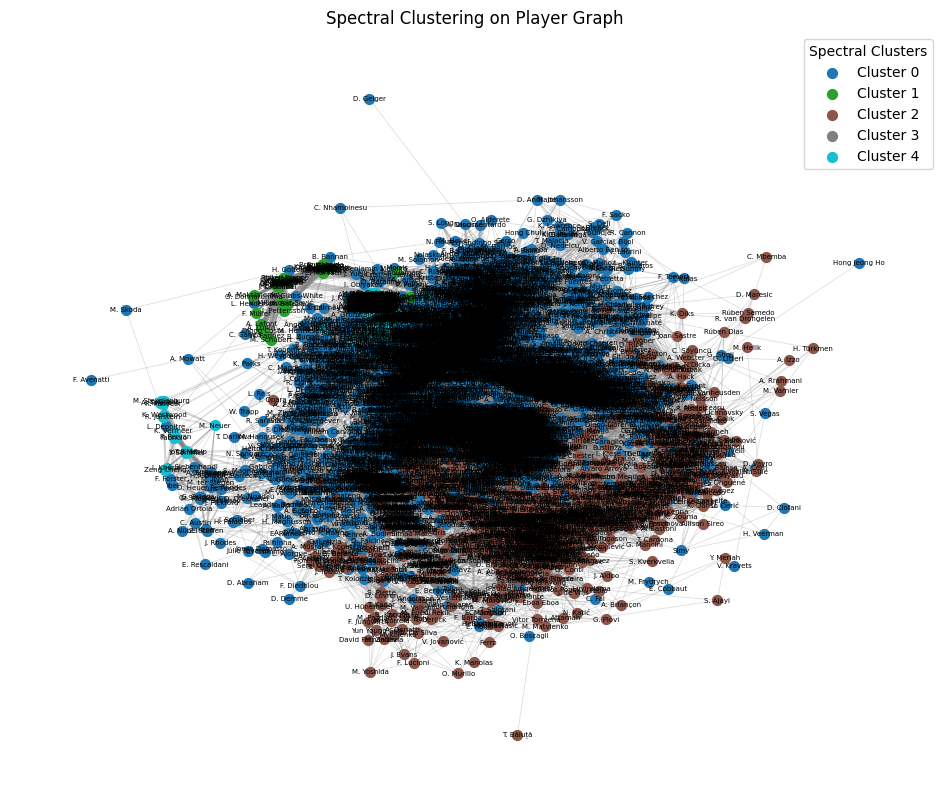

In [44]:
G.remove_nodes_from(list(nx.isolates(G)))

# Get the adjacency matrix of the graph
adj_matrix = nx.to_numpy_array(G)
adj_matrix = np.nan_to_num(adj_matrix, nan=0.0)

# Standardize the adjacency matrix to improve clustering results
#scaler = StandardScaler()
#adj_matrix_scaled = scaler.fit_transform(adj_matrix)

# Set the number of clusters
num_clusters = 5

# Perform spectral clustering on the adjacency matrix
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
cluster_labels = spectral_model.fit_predict(adj_matrix)

# Assign clusters to nodes
for idx, node in enumerate(G.nodes()):
    G.nodes[node]['spectral_cluster'] = cluster_labels[idx]

# Visualize the clusters
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.1, seed=42)

# Assign colors based on cluster labels
unique_clusters = set(cluster_labels)
color_map = plt.cm.get_cmap('tab10', len(unique_clusters))

# Draw nodes by cluster
for cluster_id in unique_clusters:
    cluster_nodes = [node for node in G.nodes() if G.nodes[node]['spectral_cluster'] == cluster_id]
    nx.draw_networkx_nodes(
        G, pos, nodelist=cluster_nodes, node_size=50,
        node_color=[color_map(cluster_id)],
        label=f"Cluster {cluster_id}"
    )

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", width=0.5)

# Draw labels with smaller font size to avoid clutter
nx.draw_networkx_labels(G, pos, font_size=5, font_color="black")

# Display the legend and title
plt.legend(scatterpoints=1, loc="best", fontsize=10, title="Spectral Clusters")
plt.title("Spectral Clustering on Player Graph")
plt.axis("off")
plt.show()